In [1]:
import pandas as pd
df = pd.read_csv('kitCapstoneJan24_data.csv', header=0, sep=';')

In [ ]:
def month_to_datestring(month: int):
    # Startpunkt Januar 2000
    m = (month - 1) % 12 + 1
    m_string = str(m) if m > 9 else '0' + str(m)
    y = (month-1) // 12
    y_string = str(y) if y > 9 else '0' + str(y)
    
    return f'{m_string}/{y_string}'

def convert_month_to_date(df: pd.DataFrame):
    df['date'] = df['month'].apply(month_to_datestring)
    df['date'] = pd.to_datetime(df['date'], format='%m/%y')
    result = df.set_index('date').drop(['month'], axis=1)
    #result.index = pd.DatetimeIndex(result.index).to_period('M')

    return result.sort_index()

df = convert_month_to_date(df.iloc[:360,:])

In [ ]:
porsche_data_country_a = df.iloc[:,:950]

#30 columns with highest correlation
corr_orderintake_porsche_country_a = df.iloc[:,:950].corr().abs().iloc[:1,:]
corr_30 = list(corr_orderintake_porsche_country_a.squeeze().nlargest(30).index)

white_list_global_consumer = ['global_consumer__unemployment_rate', 'global_consumer__total_population', 'global_consumer__total_consumption', 'global_consumer__financial_other_services', 'global_consumer__average_income', 'global_consumer__automobiles']
white_list_global_economy = ['global_economy__bop_basic_balance_euro__euro', 'global_economy__bop_goods_balance_of_gdp__percentage', 'global_economy__bop_goods_exports_euro__euro', 'global_economy__bop_goods_imports_euro__euro', 'global_consumer__consumer_price_index', 'global_economy__employment_total__persons']

for entry in white_list_global_consumer:
    corr_30.append(entry)
for entry in white_list_global_economy:
    corr_30.append(entry)

porsche_df = df[corr_30]

In [4]:
from sklearn.impute import SimpleImputer

#dropping column where no test data is available 
porsche_df = porsche_df[list(porsche_df.iloc[240:258,:].dropna(axis=1).columns)]
train_df = porsche_df.iloc[:240,:]
test_df = porsche_df.iloc[240:258,:]

#replacing missing values from columns
date_range = pd.date_range(start='2000-01-01', periods=240, freq='MS')
imputer = SimpleImputer()
train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=list(train_df.columns))
train_df.index = date_range

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape

orders = [[1,0,0], [0,0,1], [1,1,1]]
seasonal_order = [[1,0,0,12], [0,0,1,12], [1,1,1,12]]
param_list = []
mapes=0
counter=0


for column in train_df.iloc[:,1:].columns:
    best_params = {}
    index = 0

    for order in orders:
        for season in seasonal_order:
            sarimax = SARIMAX(endog=train_df[column],
                            order=order, freq='MS', seasonal_order=season)
            results = sarimax.fit()
            forecast = results.predict(start=240,end=257,dynamic=True)
            forecast = pd.DataFrame(forecast)
            mape_score = mape(test_df[column], forecast["predicted_mean"])
            params = [mape_score, order, season]
            best_params[str(index)] = params
            index+=1

    best_mape = min(best_params.values())[0]
    best_order = min(best_params.values())[1]
    best_season = min(best_params.values())[2]
    
    if best_mape<0.2:
        counter+=1
        mapes+=best_mape
        #print(f'{column} -> mape score: {best_mape} with best order: {best_order} and best season: {best_season}')
        param_list.append([column, best_order, best_season])
   
#print("Mean mape: " + str(mapes/counter))


In [6]:
date_range = pd.date_range(start='2020-01-01', periods=18, freq='MS')
# date_range = pd.date_range(start='2021-07-01', periods=18, freq='MS')
X_df = pd.DataFrame(1, index=date_range, columns=['col1'])

column_list = []

for column_triples in param_list:
    column_list.append(column_triples[0])
    sarimax = SARIMAX(endog=train_df[column_triples[0]],
                            order=column_triples[1], freq='MS', seasonal_order=column_triples[2])
    results = sarimax.fit()
    forecast = results.predict(start=240,end=257,dynamic=True)
    # forecast = results.predict(start=258,end=275,dynamic=True)
    forecast_dataframe = pd.DataFrame(forecast)
    X_df = pd.concat([X_df, forecast_dataframe], axis=1)
    X_df.columns = [*X_df.columns[:-1], column_triples[0]]


X_df.drop(columns=X_df.columns[0], axis=1, inplace=True)


c:\Users\jaspe\Desktop\Business Intelligence Systems\capstone\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\jaspe\Desktop\Business Intelligence Systems\capstone\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jaspe\Desktop\Business Intelligence Systems\capstone\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\jaspe\Desktop\Business Intelligence Systems\capstone\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarnin

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

imputer = SimpleImputer()
transformed_df = pd.DataFrame(imputer.fit_transform(train_df), columns=list(train_df.columns))

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 20)]
max_depth = [int(x) for x in np.linspace(1, 7, num = 7)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

reg = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = reg, param_distributions = random_grid, 
                               scoring='neg_mean_absolute_percentage_error', 
                               n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(transformed_df[column_list], transformed_df.iloc[:,:1])

reg = RandomForestRegressor(n_estimators=rf_random.best_params_['n_estimators'], 
                            max_depth=rf_random.best_params_['max_depth'])
reg.fit(transformed_df[column_list], transformed_df.iloc[:,:1])

date_range = pd.date_range(start='2020-01-01', periods=18, freq='MS')
prediction = pd.DataFrame(reg.predict(X_df), index=date_range, columns=['prediction'])
mape_score = mape(test_df['sales_actuals_monthly__vehiclegroup01__orderintake'], prediction["prediction"])
print(mape_score)
plt.plot(test_df['sales_actuals_monthly__vehiclegroup01__orderintake'])
plt.plot(prediction["prediction"])
plt.show()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


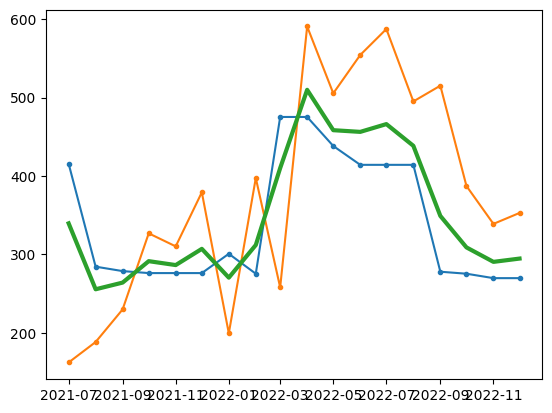

In [287]:
fabi_pred = [162.15201836135265,
 188.25444030132132,
 229.8275607245791,
 326.89832787487035,
 310.26462811263707,
 379.2045339283664,
 199.3593251609803,
 397.4650421448772,
 257.9060271305865,
 590.78947737476,
 505.5157293575055,
 554.4382877858811,
 587.5371013396211,
 495.1738027686779,
 515.2631071791129,
 387.29696554035814,
 338.95898500335306,
 352.9280245650671]

date_range = pd.date_range(start='2021-07-01', periods=18, freq='MS')
prediction = pd.DataFrame(reg.predict(X_df), index=date_range, columns=['prediction'])
fabi_df = pd.DataFrame(fabi_pred, columns=["prediction2"], index=date_range)
sum = pd.DataFrame((70*prediction["prediction"]+30*fabi_df["prediction2"])/100, columns=["sum"])

plt.plot(prediction['prediction'], marker='.')
plt.plot(fabi_df['prediction2'], marker='.')
plt.plot(sum["sum"], linewidth=3)
plt.show()

In [288]:
sum.to_csv('summed_up_predictions.csv')